# Исследование надежности клиентов банка

## Описание проекта

Заказчиком является кредитный отдел банка. Основная цель - определить наиболее надежных клиентов, которые выплатят смогут выплатить кредит без каких-либо задержек. Входные данные от банка — статистика о платёжеспособности клиентов. Результаты исследования будут учтены при построении модели кредитного скоринга.

## Описание входных данных
* `children` — количество детей в семье
* `days_employed` — общий трудовой стаж в днях
* `dob_years` — возраст клиента в годах
* `education` — уровень образования клиента
* `education_id` — идентификатор уровня образования
* `family_status` — семейное положение
* `family_status_id` — идентификатор семейного положения
* `gender` — пол клиента
* `income_type` — тип занятости
* `debt` — имел ли задолженность по возврату кредитов
* `total_income` — ежемесячный доход
* `purpose` — цель получения кредита

## Используемые библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных и анализ общей информации

In [83]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

In [84]:
# оценим общий вид данных
data.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу
5,0,-926.185831,27,высшее,0,гражданский брак,1,M,компаньон,0,255763.565419,покупка жилья
6,0,-2879.202052,43,высшее,0,женат / замужем,0,F,компаньон,0,240525.971920,операции с жильем
7,0,-152.779569,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,135823.934197,образование
8,2,-6929.865299,35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,95856.832424,на проведение свадьбы
9,0,-2188.756445,41,среднее,1,женат / замужем,0,M,сотрудник,0,144425.938277,покупка жилья для семьи


In [85]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


## Предобработка данных
### Удаление пропусков и обработка анамольных значений

In [86]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Пропуски пристуствуют в двух колонках `days_employe` и `total_income`. Пропуски в колонке `total_income`, вероятно, связаны с тем, что ежемесячный доход не указывали сами клиенты, у которых в данный момент его. К таким категориям клиентов могут относиться студенты и пенсионеры. Пропуски в колонке `days_employed`, скорее всего, имеют ту же причину, что и в колонке `total_income` - а именно то, что клиенты еще не работали и трудовой стаж равен 0, который они решили не указывать.

#### Общий трудовой стаж

In [87]:
data['days_employed'].describe()

count     19351.000000
mean      63046.497661
std      140827.311974
min      -18388.949901
25%       -2747.423625
50%       -1203.369529
75%        -291.095954
max      401755.400475
Name: days_employed, dtype: float64

В столбце `days_employed` присутствуют отрицательные значения, в которых в действительности не может измеряться общий трудовой стаж. Возьмем модуль для всего столбца. И после чего заменим пропуски медианным значением в зависимости от типа дохода.

In [88]:
data['days_employed'] = data['days_employed'].abs()

In [89]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [90]:
# оценим общий трудовой стаж в зависимости от социального статуса клиента
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

У двух типов (безработные и пенсионеры) получаются аномально большие значения. Исправить такие значения сложно, поэтому данный столбец будет некорректно использовать для анализа.

#### Уровень ежемесячного дохода

In [91]:
data['total_income'].describe()

count    1.935100e+04
mean     1.674223e+05
std      1.029716e+05
min      2.066726e+04
25%      1.030532e+05
50%      1.450179e+05
75%      2.034351e+05
max      2.265604e+06
Name: total_income, dtype: float64

Колонка с данными по ежемесячному уровеню дохода выглядит адекватно. Заменим пропуски медианным значением аналогично колонке `days_employed`.

In [92]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

Заполнение пропусков медианным значением является лучшим вариантом, если мы не можем восстановить реальные данные, так как в медиану, вероятнее всего, не попадут выбросы, которые могут присутствовать в данных. А выполняя группировку по какому-либо другому фактору или факторам (например, по типу занятости клиента) и рассчитывая медиану уже внутри групп - мы можем достаточно достоверно заполнить пропуски разными медианными значениями.

#### Количество детей у клиента

In [93]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5])

In [94]:
data[data['children'].isin([-1, 20])]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
291,-1,4417.703588,46,среднее,1,гражданский брак,1,F,сотрудник,0,102816.346412,профильное образование
606,20,880.221113,21,среднее,1,женат / замужем,0,M,компаньон,0,145334.865002,покупка жилья
705,-1,902.084528,50,среднее,1,женат / замужем,0,F,госслужащий,0,137882.899271,приобретение автомобиля
720,20,855.595512,44,среднее,1,женат / замужем,0,F,компаньон,0,112998.738649,покупка недвижимости
742,-1,3174.456205,57,среднее,1,женат / замужем,0,F,сотрудник,0,64268.044444,дополнительное образование
...,...,...,...,...,...,...,...,...,...,...,...,...
21140,-1,1422.668059,44,среднее,1,женат / замужем,0,F,компаньон,0,169562.091999,операции со своей недвижимостью
21325,20,601.174883,37,среднее,1,женат / замужем,0,F,компаньон,0,102986.065978,профильное образование
21390,20,1547.382223,53,среднее,1,женат / замужем,0,M,компаньон,0,172357.950966,покупка жилой недвижимости
21404,20,494.788448,52,среднее,1,женат / замужем,0,M,компаньон,0,156629.683642,операции со своей недвижимостью


Удалим строки в которых указаны некорректные значения, так как таких строк всего 123 из 21 тысячи.

In [95]:
data = data[~data['children'].isin([-1, 20])]

In [96]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5])

In [97]:
# убедимся, что пропусков не осталось
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

### Изменение типов данных

In [98]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

In [99]:
data['education'].value_counts()

среднее                13667
высшее                  4698
СРЕДНЕЕ                  766
Среднее                  703
неоконченное высшее      665
ВЫСШЕЕ                   271
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
Ученая степень             1
УЧЕНАЯ СТЕПЕНЬ             1
Name: education, dtype: int64

In [100]:
# приведем данные в колонке "образование" к одному виде, тем самым удалим неявные дубликаты
data['education'] = data['education'].str.lower()

In [101]:
# оценим явные дубликаты и удалим их
data.duplicated().sum()

71

In [102]:
data = data.drop_duplicates()

### Категоризация данных
#### Уровень ежемесяыного дохода

На основании диапазонов, указанных ниже, создадим в датафрейме `data` столбец `total_income_category` с категориями:**

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [103]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [104]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

#### Цель кредита

Выведем на экран перечень уникальных целей взятия кредита из столбца `purpose`

In [106]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [107]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [108]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## Исследование данных

### Есть ли зависимость между количеством детей и возвратом кредита в срок?

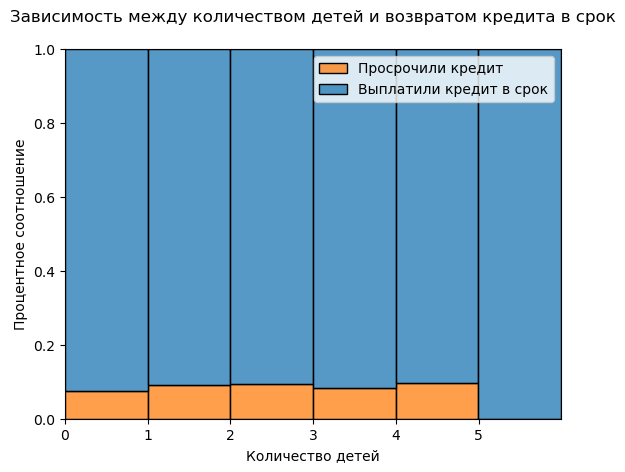

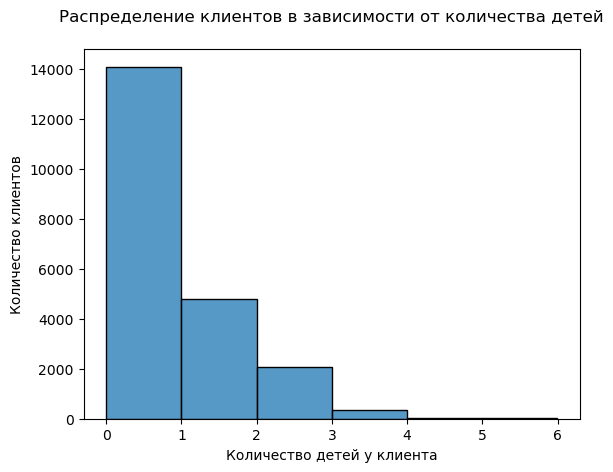

In [109]:
sns.histplot(data, x='children', hue='debt', multiple='fill', linewidth=1, binwidth=0.999)
plt.title('Зависимость между количеством детей и возвратом кредита в срок', pad=20)
plt.legend(['Просрочили кредит', 'Выплатили кредит в срок'])
plt.xlabel('Количество детей')
plt.ylabel('Процентное соотношение')
plt.show()

sns.histplot(data, x='children', linewidth=1, binwidth=0.999)
plt.title('Распределение клиентов в зависимости от количества детей', pad=20)
plt.ylabel('Количество клиентов')
plt.xlabel('Количество детей у клиента')
plt.show()

In [110]:
data.pivot_table(index='children',values='debt', aggfunc=('count',
                                                          'sum',
                                                          'mean'))

,count,mean,sum
children,,,
0,14091,0.075438,1063
1,4808,0.092346,444
2,2052,0.094542,194
3,330,0.081818,27
4,41,0.097561,4
5,9,0.000000,0


**Вывод:** оценив гистограммы можно понять, что общее процентное соотношение клиентов, которые смогли выплатить кредит в срок к клиентам, которые его просрочили приблизительно одинаковое в независимости от количества детей *(если их больше 0)*. Исключением являются клиенты с 5 детьми - они всегда выплачивали кредит в срок, но если посмотреть на абсолютные цифры, то таких клиентов было всего 9 из 21 тысячи человек, поэтому нельзя сказать с увернностью, что если у клиента 5 детей, то он со 100% вероятностью закроет кредит в срок. Таким образом, предполагаем, что явной зависимости между количеством детей и возвратом кредита в срок нет. *Однако стоит отметить, что клиенты, у которых нет детей выплачивают кредит в срок чаще, чем клиенты у которых есть хотя бы один ребенок.*

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

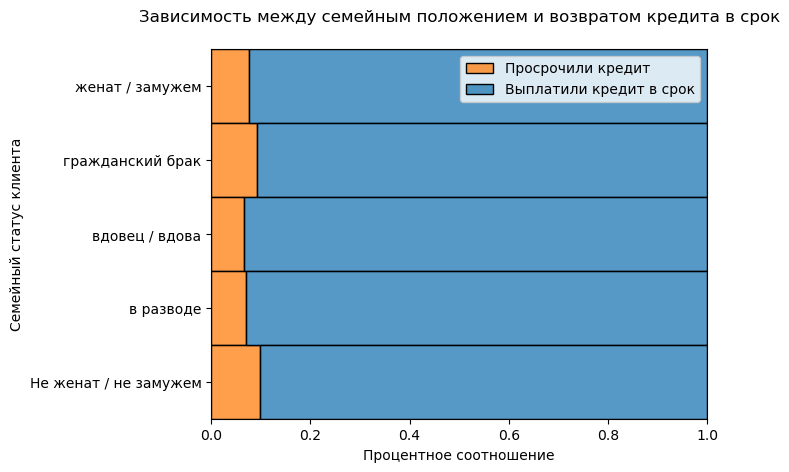

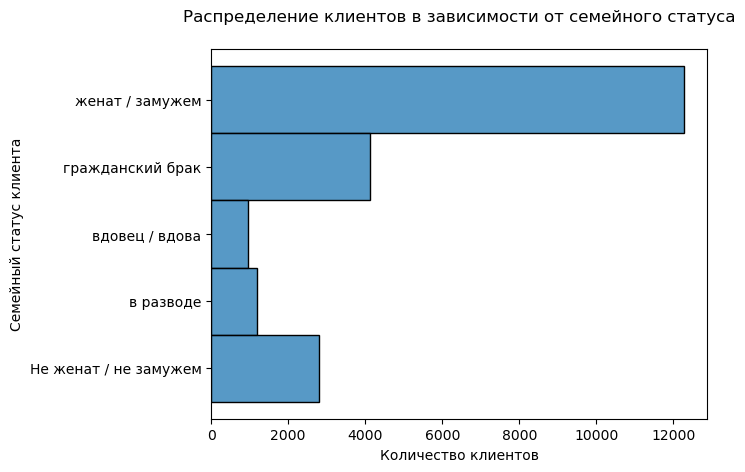

In [111]:
sns.histplot(data, y='family_status', hue='debt', multiple='fill', linewidth=1)
plt.title('Зависимость между семейным положением и возвратом кредита в срок', pad=20)
plt.legend(['Просрочили кредит', 'Выплатили кредит в срок'])
plt.ylabel('Семейный статус клиента')
plt.xlabel('Процентное соотношение')
plt.show()

sns.histplot(data, y='family_status', linewidth=1)
plt.title('Распределение клиентов в зависимости от семейного статуса', pad=20)
plt.ylabel('Семейный статус клиента')
plt.xlabel('Количество клиентов')
plt.show()

In [112]:
data.pivot_table(index='family_status',values='debt', aggfunc=('count',
                                                               'sum',
                                                               'mean'))

,count,mean,sum
family_status,,,
Не женат / не замужем,2796,0.097639,273
в разводе,1189,0.070648,84
вдовец / вдова,951,0.066246,63
гражданский брак,4134,0.093130,385
женат / замужем,12261,0.075606,927


**Вывод:** клиенты банка в семейном статусе "Гражданский брак" и "Не женат / не замужем" реже выплачивают кредит в срок. И чаще всего кредит в срок возвращают клиенты в статусе "Вдовец / вдова". *Можно предположить, что овдовевшие клиенты (как и клиенты в разводе) более дисциплинированы, так как, когда человек один, ему проще планировать свой бюджет и полагаться только на свои силы, однако данные по клиентам в статусе "Не женат / не замужем" говорят об обратном - самый большой процент просрочки кредита. В таком случае, вероятно, важной составляющей является этап семейной жизни, в процессе которого меняются привычки человека: он становится рациональнее, реже совершает спонтанные покупки и учится планировать свой бюджет. Как раз эти привычки и помогают людям после брака выплачивать кредит в срок чаще остальных категорий клиентов.*

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

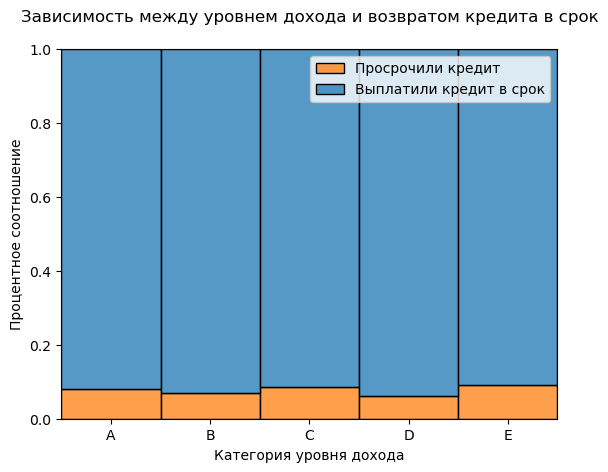

In [113]:
sns.histplot(data.sort_values('total_income_category'),
             x='total_income_category',
             hue='debt',
             multiple='fill',
             linewidth=1)
plt.title('Зависимость между уровнем дохода и возвратом кредита в срок', pad=20)
plt.legend(['Просрочили кредит', 'Выплатили кредит в срок'])
plt.xlabel('Категория уровня дохода')
plt.ylabel('Процентное соотношение')
plt.show()

In [114]:
data.pivot_table(index='total_income_category',values='debt', aggfunc=('count',
                                                               'sum',
                                                               'mean'))

,count,mean,sum
total_income_category,,,
A,25,0.080000,2
B,5014,0.070602,354
C,15921,0.084982,1353
D,349,0.060172,21
E,22,0.090909,2


                       count      mean   sum
total_income_category                       
A                         25  0.080000     2
B                       5014  0.070602   354
C                      15921  0.084982  1353
D                        349  0.060172    21
E                         22  0.090909     2


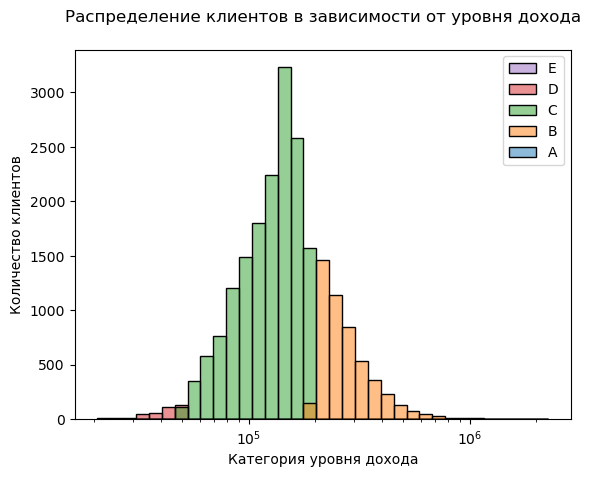

In [115]:
print(data.pivot_table(index='total_income_category',values='debt', aggfunc=('count', 'sum', 'mean')))

sns.histplot(data.sort_values('total_income_category'),
             x='total_income',
             linewidth=1,
             bins=35,
             hue='total_income_category',
             log_scale=True) # покажем в логарифмическом масштабе
plt.legend(labels=sorted(data['total_income_category'].unique(), reverse=True))
plt.title('Распределение клиентов в зависимости от уровня дохода', pad=20)
plt.ylabel('Количество клиентов')
plt.xlabel('Категория уровня дохода')
plt.show()

**Вывод:** по гистограмме распределения клиентов в зависимости от уровня дохода видно, что большую часть составляют клиенты группы 'C' и группы 'B'. *Причем в процентном соотношении клиенты групп 'C' и 'B' составляют около 98% от всех клиентов (около 21 тысячи). И если по группе 'D' может быть и можно сделать анализ, то группы 'A' и 'E' - это слишком маленькие выборки, на основе которых нельзя делать выводы о зависимости между уровнем дохода и возвратом кредита в срок. Сравнивая клиентов по уровню дохода можно сказать, что люди с доходом от 50 000 до 200 000 реже выплачивают кредит вовремя, в сравнении с клиентами, которые имеют от 200 000 до 1 000 000 ежемесячного дохода. Если предположить, что выборка группы 'D' является сбалансированной и репрезентативной, то клиенты данной группы являются фаворитами по выплатам кредита в срок.*

### Как разные цели кредита влияют на его возврат в срок?

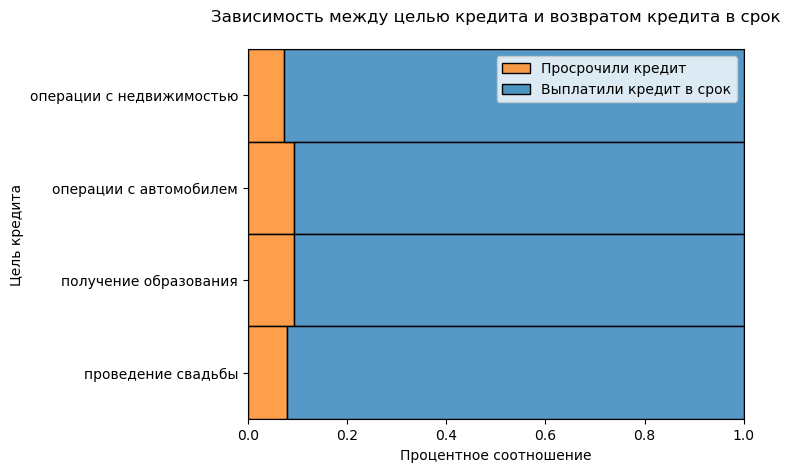

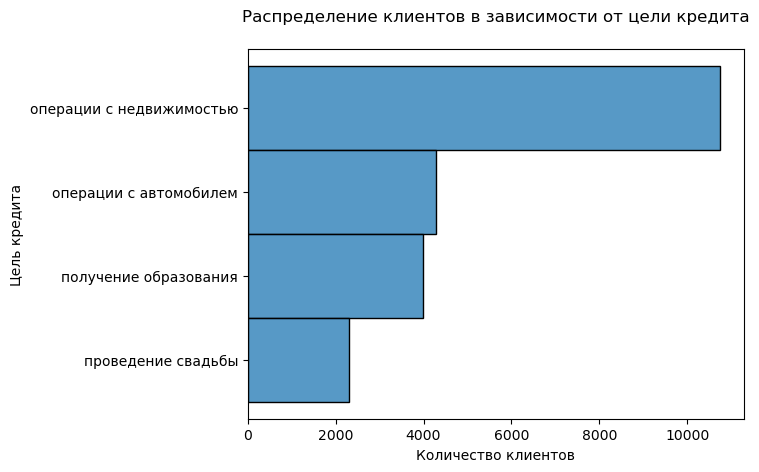

In [116]:
sns.histplot(data, y='purpose_category', hue='debt', multiple='fill', linewidth=1)
plt.title('Зависимость между целью кредита и возвратом кредита в срок', pad=20)
plt.legend(['Просрочили кредит', 'Выплатили кредит в срок'])
plt.ylabel('Цель кредита')
plt.xlabel('Процентное соотношение')
plt.show()

sns.histplot(data, y='purpose_category', linewidth=1)
plt.title('Распределение клиентов в зависимости от цели кредита', pad=20)
plt.ylabel('Цель кредита')
plt.xlabel('Количество клиентов')
plt.show()

**Вывод:** наиболее частые кредиты - это кредиты для операций с недвижимостью, однако по ним соотношение просрочивших кредит клиентов к выплатившим кредит вовремя, меньше чем в остальных категориях кредита. Клиенты, которые берут кредит для операций с автомобилем и получения образования реже остальных выплачивают кредит вовремя.

## Общий вывод

В ходе выполнения проекта был изучен датасет статистики о платёжеспособности клиентов банка. Посмотрев на данные можно оценить, что они представлены в достаточно полном виде, однако встречались пропуски, явные дубликаты и аномальные значения, которые в дальнейшем были обработаны:
- Пропуски были заполнены медианными значениями, которые были рассчитаны внутри групп по типу занятости клиентов
- Дубликаты были удалены, как и строки, содержащие аномальные значения, в факторах, которые были важны для дальнейшего анализа

Затем была произведена категоризация непрерывного признака `total_income`, в результате чего он был использован для выяснения зависимости между уровнем дохода и возвратом кредита в срок. Также были изучены следующие зависимости факторов между:
- количеством детей и возвратом кредита в срок
- семейным положением и возвратом кредита в срок

Для оценки влияния зависимости между целью кредита и возвратом его без просрочки было необходимо провести категоризацию целей, которые указывали клиенты. В результате чего были получены конкретные цели кредита: операции с недвижимостью, проведение свадьбы, получение образования, покупка автомобиля.

В процессе проведения анализа по выявлению платежеспособных клиентов были сделаны **следующие выводы**:
1. Клиенты без детей выплачивают кредит в срок чаще, чем клиенты у которых есть хотя бы один ребенок;
2. Статус семейного положения также влияет на вероятность вернуть кредит вовремя: овдовевшие или же клиенты в разводе платежеспособнее, чем холостые и незамужние;
3. По уровню ежемесячного дохода тоже можно оценить вероятность выплаты кредита без задержки. Среди всех клиентов банка было выделено 5 групп по уровню дохода, однако с уверенностью можно назвать репрезентативными только 2 группы, на которые приходится 98% всех наблюдений: группа с доходом от 50 000 до 200 000 и от 200 000 до 1 000 000. И если сравнивать две эти группы, то клиенты, чей ежемесячный доход составляет от 200 тысяч до 1 миллиона выплачивают кредит стабильнее;
4. Кредит для операций с недвижимостью является не только самым распространенным, но и вовремя его выплачивают лучше всех остальных.

Таким образом, идеальный заемщик - это овдовевший человек с ежемесячным доходом от 200 тысяч до 1 миллиона, у которого нет детей, но которому нужны средства для операций с недвижимостью 😅